Test generating CO2 for 2025-2029

Uses the 2022-12-23 version from https://github.com/Jete90/AERA
https://github.com/Jete90/AERA/commit/d0251d8f8cfc5503f959ab35089f3a2a26875318

In [1]:
import sys, numpy as np
import matplotlib.pyplot as plt
import xarray as xr
sys.path.append('/g/data1a/p66/mrd599/venv/aera/lib/python3.9/site-packages')
import aera
from pathlib import Path
import time
import pandas as pd
import mule
from mule.operators import ScaleFactorOperator
from notebook_metadata import create_savefig

savefig = create_savefig(dir='/g/data/p66/mrd599/temp', nb='aera_co2_update_new.ipynb')

In [2]:
year = 2025
RUNID = 'AERA-ABS1p5-03.nc'
# File extends to 2025
d = xr.load_dataset('/scratch/p66/mrd599/aera_input_AERA-ABS1p5-03.nc')
# d_pi = xr.load_dataset('/g/data/p66/mrd599/AERA/aera_input_PI.nc', use_cftime=True)
luc = xr.load_dataset('/g/data/p66/mrd599/AERA/luc_emissions.nc').luc
luc_21 = xr.load_dataset('/g/data/p66/mrd599/AERA/luc_emissions_21.nc').luc
tas = d.tas
co2 = d.co2
# tas_pi = d_pi.tas
# co2_pi = d_pi.co2
C_CO2        = 1.5188
target = 1.5
ABS = True

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/coding/times.py:699: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [3]:
"""Filled template1.py for use with ACCESS ESM1.5

An "AERA run script" will load all the neccessary time series from
your ESM simulation and call the AERA algorithm with this data.
Finally it will save the near-future fossil fuel CO2 emissions in
a format that is compatible with your ESM (e.g. as a NetCDF file).

Usage:
    $ python SCRIPT_NAME SIMULATION_DIRECTORY STOCKTAKE_YEAR \
        REL_TEMP_TARGET TEMP_TARGET_TYPE

EXAMPLE RUN COMMANDS:
    1)
    $ python template1_filled_gfdl.py $SCRATCH/AERA_T15_1_ENS1 2025 1.5 1
    This command runs the AERA algorithm for the simulation
    "AERA_T15_1_ENS1" (stored in $SCRATCH/AERA_T15_1_ENS1) and
    the stocktake year 2025 (thus it calculates emissions for the
    period 2026-2030) with a relative temperature target of 1.5K.
    The temperature target is calculated relative to
    the observed anthropogenic warming in 2020 ("type 1 temperature
    target").

    2)
    $ python template1_filled_gfdl.py $SCRATCH/AERA_T25_2_ENS1 2060 2.5 2
    This command runs the AERA algorithm for the simulation
    "AERA_T25_2_ENS1" (stored in $SCRATCH/AERA_T25_2_ENS1) and
    the stocktake year 2060 (thus it calculates emissions for the
    period 2061-2065) with a relative temperature target of 2.5K.
    The temperature target is calculated relative to
    the mean temperature in the ESM in the period 1850-1900
    ("type 2 temperature target").

TODO: If you want to adapt the following script, first jump to all
the TODOs (lines that start with "# TODO") in the script and
make according changes.

SOLVED: In addition to the "TODO comments" there are some
"SOLVED comments" (lines that start with "# SOLVED") to clarify
where code was changed/inserted.

"""
import datetime
from pathlib import Path
import sys
import time

import cftime
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import xarray as xr

import aera

if ABS:
    TEMP_TARGET_TYPE = 2
else:
    TEMP_TARGET_TYPE = 1

PROJECT_DIR = Path('/project/s996/maschwan')
# Directory where several aera specific file are stored.
AERA_DATA_DIR = PROJECT_DIR / 'aera_data'
AERA_DATA_DIR = Path('/scratch/p66/mrd599')
AERA_DATA_DIR = Path('/scratch/p66/mrd599')


###########
# CONSTANTS
###########
# Model start year: Defines in which year the ESM historical run
# starts.
MODEL_START_YEAR = 1850

# Enable/Disable output of debug information
DEBUG = True

######################
# READ INPUT ARGUMENTS
######################
SIMULATION_DIR = Path(sys.argv[1])
YEAR_X = year # int(sys.argv[2])
REL_TEMP_TARGET = target # float(sys.argv[3])
# TEMP_TARGET_TYPE = int(sys.argv[4])

# Verify that the given stocktake year (YEAR_X) is valid
if YEAR_X % 5 != 0:
    raise ValueError(
        f'YEAR_X is not valid ({YEAR_X})! Abort adaptive emission calculation.'
        'YEAR_X must be divisible by 5 (e.g. 2025, 2030, 2035).')

AERA_DIR = SIMULATION_DIR / 'AERA'
AERA_DIR = Path('/scratch/p66/mrd599')
OUTPUT_EMISSION_FILE = SIMULATION_DIR / 'INPUT/co2_emission.nc'
EMISSION_CSV_FILE = AERA_DIR / f'ff_emission.csv'
# 1 Pg C-normalized 3D (time, lat, lon) monthly fossil fuel emission file
YEAR_EMISSION_FILE = AERA_DIR / 'emission_pattern_1Pg_1year.nc'


###################################
# COLLECT DATA AND CREATE DATAFRAME
###################################
# The AERA algorithm needs several time series as its input.
# To make the usage of the algorithm easier and to assure
# that the input data is correctly formated the main function
# `aera.get_adaptive_emissions` takes a pandas.DataFrame as its
# input.
# The `aera` module also provides a function which returns
# a "template dataframe". The data in this dataframe can now be
# overwritten with the data from the running simulation.

# Get the template dataframe
df = aera.get_base_df()

# This dataframe contains the following columns
# - non_co2_emission
# - ff_emission
# - lu_emission
# - temp
# The index of the dataframe is "year".
#
# TODO(2): The columns ff_emission and temp MUST be provided
#       (i.e. the data in the dataframe in these columns must be set)
# TODO(2) (optional): The 'standard' data in the columns
#       non_co2_emission, and lu_emission should also be provided if
#       model-specific time series are available.
#
# Note: For all these time series except ff_emission, data from
# `MODEL_START_YEAR` until `YEAR_X` must be provided (e.g. 1850-2025).
# The fossil fuel emissions must be provided from 2026 onward.
# Before 2026 all models should have identical (or very similar)
# emissions (only after 2026 they begin to use the AERA algorithm),
# therefore the fossil fuel emission data from 1700 until 2025 is
# contained in the AERA python module.
#
# To provide the above mentioned data:
#   1) Load the data (e.g. using xarray.open_dataset)
#   2) Calculate global annual mean values
#   3) Overwrite values in `df`
#
# This could look something like:
# df['temp'].loc[MODEL_START_YEAR:YEAR_X] =
# df['ff_emission'].loc[2026:YEAR_X] =
# (optional): df['non_co2_emission'].loc[MODEL_START_YEAR:YEAR_X] =
# (optional): df['lu_emission'].loc[MODEL_START_YEAR:YEAR_X] =

# SOLVED(2): In the following temperature, CO2 concentration,
#       fossil fuel emission (from 2026 onward), and non-CO2
#       emission time series are loaded and
#       written into the dataframe "df".


# Temperature
df['temp'].loc[MODEL_START_YEAR:YEAR_X] = tas.values
df['lu_emission'].loc[:] = 0.
# LUC file goes to 2500 but other AERA data only to 2499
df['lu_emission'].loc[MODEL_START_YEAR:2499] = luc.values[:-1]
# rf_save = df['rf_non_co2'].copy()
# df['rf_non_co2'].loc[1950:1969] -= np.linspace(0,0.5,20)
# df['rf_non_co2'].loc[1970:1999] -= 0.5
# df['rf_non_co2'].loc[2000:2020] -= np.linspace(0.5,0,21)

# Fossil fuel emission
try:
    # Fossil fuel data is loaded directly from the CSV file
    # which is written out by this script (thus only data is
    # loaded which was previously calculated by this script).
    _df_tmp = pd.read_csv(EMISSION_CSV_FILE, index_col=0).dropna()
    values = _df_tmp.loc[2026:YEAR_X].values.flatten()
    df['ff_emission'].loc[2026:YEAR_X] = values
except FileNotFoundError:
    print(
        EMISSION_CSV_FILE, 'doesn\'t exist. '
        'Only emissions after 2025 are available.')

#####################
# CALL AERA ALGORITHM
#####################
# Using the above created dataframe `df` we can now call the
# AERA algorithm:
s_emission_future = aera.get_adaptive_emissions(
    temp_target_rel=REL_TEMP_TARGET,
    temp_target_type=TEMP_TARGET_TYPE,
    year_x=YEAR_X,
    model_start_year=MODEL_START_YEAR,
    df=df,
    meta_file=AERA_DIR/f'meta_data_new_{YEAR_X}.nc',
    )

# The future ff emissions are saved to a CSV file. But the ff emission
# also must be saved in a format which can be read by the ESM in use.
s_emission = df['ff_emission']
s_emission.update(s_emission_future)
s_emission.to_csv(EMISSION_CSV_FILE)


####################################
# WRITE NEAR-FUTURE FF CO2 EMISSIONS
####################################


#############################
# WRITE DEBUG INFORMATION
#############################
# Print out some debug information and also write these to a file
if DEBUG:
    debug_str = (
        'INPUT ARGUMENTS: \n'
        f'[DEBUG] Year X: {YEAR_X}\n'
        f'[DEBUG] Relative Target Temperature: {REL_TEMP_TARGET}\n'
        f'[DEBUG] Target Temperature Type: {TEMP_TARGET_TYPE}\n'
        f'[DEBUG] Model start year: {MODEL_START_YEAR}\n\n\n\n'
        'OUTPUT: \n'
        f'[DEBUG] Calculated the following emissions: {s_emission_future}'
        )

    try:
        debug_filename = f'{YEAR_X}_{int(time.time())}.debug'
        # The debug file will be created where the "AERA run script" lies
        debug_file = AERA_DIR / debug_filename
        with open(debug_file, 'w') as f:
            f.write(debug_str)
    except PermissionError:
        print('[WARNING] Failed to write the debug information '
              f'to {debug_file} (permission denied).')


Use the following non-CO2 emission file: /g/data1a/p66/mrd599/venv/aera/lib/python3.9/site-packages/aera/data/nonco2_emis_ssp126_v3.dat
Use the following land use emission file: /g/data1a/p66/mrd599/venv/aera/lib/python3.9/site-packages/aera/data/lu_emis_ssp126_bern3d_adj_GCB2020_v1.dat
Use the following historical fossil fuel CO2 emission file: /g/data1a/p66/mrd599/venv/aera/lib/python3.9/site-packages/aera/data/co2_ff_GCP_plus_NDC_v1.dat
Relative anthropogenic warming in Year X:  1.2318387149180126
Cumulative past emissions:  632.4829278413133
REB:  137.68639730862256
CO2-fe emissions [Pg C] (fossil fuel CO2 + landuse + non-CO2) over next years:
year
2026    1.221678e+01
2027    1.190923e+01
2028    1.150753e+01
2029    1.102227e+01
2030    1.046403e+01
2031    9.843388e+00
2032    9.170929e+00
2033    8.457236e+00
2034    7.712893e+00
2035    6.948480e+00
2036    6.174582e+00
2037    5.401781e+00
2038    4.640660e+00
2039    3.901800e+00
2040    3.195786e+00
2041    2.533198e+00
204

NameError: name 'MODEL_CO2_PREINDUSTRIAL' is not defined

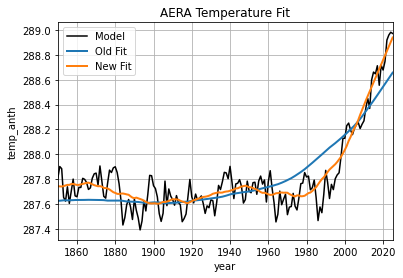

In [13]:
dm_2025_std = xr.load_dataset('/scratch/p66/mrd599/meta_data_2025_std.nc')
dm_2025_mod = xr.load_dataset('/scratch/p66/mrd599/meta_data_2025.nc')
dm_2025_new = xr.load_dataset('/scratch/p66/mrd599/meta_data_new_2025.nc')
fig, axes = plt.subplots()
plt.plot(np.arange(1850,1850+len(tas)), tas.data, label='Model', color='black')
dm_2025_std.temp_anth[0].plot(label='Old Fit', lw=2)
# dm_2025_mod.temp_anth[0].plot(label='Old Fit modified RF')
dm_2025_new.temp_anth[0].plot(label='New Fit', lw=2)
axes.legend()
axes.set_title('AERA Temperature Fit')
axes.set_xlim(1850,2025)
axes.grid(True)
savefig('aera_temp_fit.png')

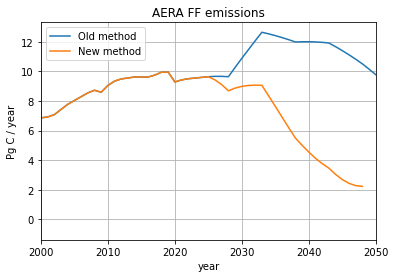

In [14]:
fig, axes = plt.subplots()
dm_2025_std.ff_emission[0].plot(label='Old method')
# dm_2025_mod.ff_emission[0].plot(label='Old method: modified RF')
dm_2025_new.ff_emission[0].plot(label='New method')
axes.legend()
axes.set_title('AERA FF emissions')
axes.grid(True)
axes.set_ylabel('Pg C / year')
axes.set_xlim(2000,2050)
savefig('aera_new_ff.png')

In [ ]:
d1p5_bern = pd.read_csv('/scratch/p66/mrd599/ff_emission_1p5_bern_luc.csv')
d1p5 = pd.read_csv('/scratch/p66/mrd599/ff_emission_1p5.csv')
df_luc21 = pd.read_csv('/scratch/p66/mrd599/ff_emission_1p5_luc21.csv')

In [ ]:
fig, axes = plt.subplots()
plt.plot(d1p5_bern['year'], d1p5_bern['ff_emission'], label='1.5 with Bern LUC')
plt.plot(d1p5['year'], d1p5['ff_emission'], label='1.5 with ESM LUC')
plt.plot(df_luc21['year'], df_luc21['ff_emission'], label='1.5 with ESM 21 year LUC')
axes.grid(True)
axes.legend()
axes.set_xlim(1950,2100)
fig, axes = plt.subplots()
plt.plot(d1p5_bern['year'], d1p5_bern['ff_emission'], label='1.5 with Bern LUC')
plt.plot(d1p5['year'], d1p5['ff_emission'], label='1.5 with ESM LUC')
plt.plot(df_luc21['year'], df_luc21['ff_emission'], label='1.5 with ESM 21 year LUC')
axes.grid(True)
axes.legend()
# axes.set_xlim(1950,2100)
axes.set_xlim(2020,2030)
axes.set_ylim(9,12)

In [ ]:
# Use s_emission_future to create an emissions file for the next period
ancil = mule.AncilFile.from_file('/g/data/p66/mrd599/AERA/CO2_fluxes_AERA_ABS1p5-03.anc')
ancil_new = ancil.copy(include_fields=True)

# First year in this is 2014 which is the base year for scaling emissions
FF_2014 = 9.84576 # ESM1.5 emissions (from CO2_2015_20025.ipynb)

# for y in range(YEAR_X+1,2086):
for y in range(YEAR_X+1,YEAR_X+6):
    scale_factor = s_emission_future[y] / FF_2014
    print(y, scale_factor)
    scale_op = ScaleFactorOperator(scale_factor)
    for mon in range(12):
        newff = scale_op(ancil.fields[mon])
        newff.lbyr = y + mon//12
        newff.lbyrd = y + mon//12
        ancil_new.fields.append(newff)

ancil_new.to_file('/g/data/p66/mrd599/AERA/CO2_fluxes_new.anc')


In [ ]:
np.linspace(0.5,0,21)